In [1]:

import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from torchvision import transforms


In [2]:
demo = False
data_dir = '..\data1\cifar-100-python/'


In [3]:
trans = transforms.ToTensor()
train = torchvision.datasets.CIFAR100(
    root="../data1", train=True, transform=trans, download=True)
test = torchvision.datasets.CIFAR100(
    root="../data1", train=False, transform=trans, download=True)
# print(train[0][0][0])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def unpickle(file):
    import _pickle
    with open(file, 'rb') as fo:
        dict = _pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# 解压后meta的路径
metaPath = '..\data1\cifar-100-python/meta'
# 解压后train的路径
trainPath = '..\data1\cifar-100-python/train'
meta = unpickle(metaPath)
train1 = unpickle(trainPath)
#标签匹配
def labels_fit(meta, train,):
    labelList ={}
    arrlabels=[]
    arrfine=[]
    arrcoarse=[]
    for i in range (0,100):
#         print(i)
        arrlabels.append(0)
        arrfine.append(0)
        arrcoarse.append(0)

    for fineLabel, coarseLabel in zip(train[b'fine_labels'], train[b'coarse_labels']):
        # print(fineLabel)
        # print("--",coarseLabel,"--")
        # if fineLabel not in fineLabelNameDict.keys():
        if arrlabels[fineLabel] == 0:
           arrfine[fineLabel]= meta[b'fine_label_names'][fineLabel].decode('utf-8')
           arrcoarse[fineLabel] = meta[b'coarse_label_names'][ coarseLabel].decode('utf-8')
    return arrlabels,arrcoarse,arrfine

finlabels_number,coarselabels,finlabels = labels_fit(meta,train1)

In [6]:
def labeld_dir(finl):#返回标签字典
    lable={}
    num = range(0,100)
    for i,j in zip(num,finl):
#         print(i,j)
#         print(type(j))
        if i not in lable.keys():
            lable[i]=j
        else:
#             print("rewrite")
            continue
    return lable

In [7]:
#标签字典
lables = labeld_dir(finlabels)
# print(type(lables.value()))

In [8]:
batch_size = 32


In [9]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [10]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [11]:
train_valid_ds = train
train_size = int(0.9 * len(train))
valid_size = len(train) - train_size
train_ds, valid_ds = torch.utils.data.random_split(train, [train_size, valid_size])

In [12]:
train_iter,train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset,batch_size,shuffle = True, drop_last = True)
    for dataset in (train_ds,train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(
    valid_ds,batch_size,shuffle = False,drop_last = True)

test_iter = torch.utils.data.DataLoader(
    test,batch_size,shuffle = False,drop_last = False)

In [13]:
def get_net():
    num_classes = 100
    net = d2l.resnet18(num_classes,3)
    return net
loss = nn.CrossEntropyLoss(reduction="none")

In [14]:
def train(net,train_iter,valid_iter,num_epochs,lr,wd,gpu,
         lrperiod,lr_decay):
    trainer = torch.optim.SGD(net.parameters(),lr = lr,)

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.887, train acc 0.735, valid acc 0.512
31.0 examples/sec on [device(type='cpu')]


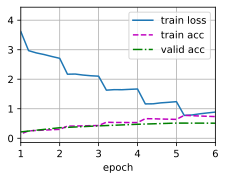

In [19]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(),6,2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [40]:

Accumulator = d2l.Accumulator

In [43]:
def evaluate_accuracy(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0],metric[0] / metric[1]